## Example CMB likelihood code

The notebook shows you how to use the CMB likelihood code to do several different things.

- Load in the Planck data and an associated noise estimate.
- Generate theoretical CMB Power Spectra from CAMB.
- Build and evaluate likelihood functions for given data sets
- Generate observations from an instrument given a noise profile and
    theoretical signal model.

In [1]:
import matplotlib.pyplot as plt
from tools.cmb import CMB
import numpy as np

# Loading Planck data and evaluating the likelihood

The code block below shows you how to load in and plot the Planck data and Planck noise power sepctrum. It also shows you how to evaluate CAMB for a set of cosmological parameters. The cosmological parameters are

- $\Omega_b h^2$: The baryon over density multiplied by $H_0/100$.
- $\Omega_c h^2$: The dark matter over density.
- $\tau$: The CMB optical depth.
- $\theta_{MC}$: The angualar scale of acoustic oscillations.
- $A_s$: The amplitude of the primordial scalar power spectrum
- $n_s$: The slop of the primordial scalar power spectrum

/Users/harrybevins/Documents/Current-projects/cmb-likelihood/tools/cmb.py:133: RuntimeWarning: divide by zero encountered in divide
  cl *= (2*np.pi)/(np.arange(len(cl))*(np.arange(len(cl))+1)) # convert to C_l
/Users/harrybevins/Documents/Current-projects/cmb-likelihood/tools/cmb.py:133: RuntimeWarning: invalid value encountered in multiply
  cl *= (2*np.pi)/(np.arange(len(cl))*(np.arange(len(cl))+1)) # convert to C_l


Likelihood:  515.819907091522


Text(0, 0.5, '$\\ell(\\ell+1)C_\\ell/2\\pi$')

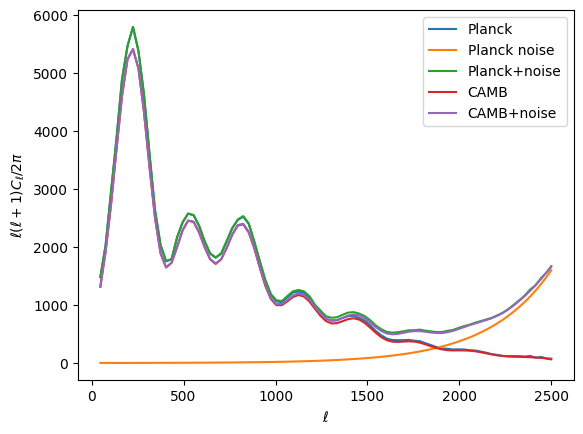

In [2]:

# the generator
cmb_generator = CMB()

# planck best fit paraemters
theta = [0.022, 0.12, 1.04, 0.06, 0.96, 3.0]
# get the planck data
planck, l = cmb_generator.get_planck()
# get an estimate of the planck instrument noise
noise = cmb_generator.get_noise(l)

plt.plot(l, planck*(l*(l+1)/(2*np.pi)),label='Planck')
plt.plot(l, noise*(l*(l+1)/(2*np.pi)), label='Planck noise')
plt.plot(l, (planck+noise)*(l*(l+1)/(2*np.pi)), label='Planck+noise')

# build the likelihood function with planck data
likelihood = cmb_generator.get_likelihood(planck, l, noise)
# evaluate planck likelihood at the planck best fit parameters
print('Likelihood: ', likelihood(theta)[0])

model = cmb_generator.get_camb_model(theta)
model = np.interp(l, np.arange(len(model)), model)

plt.plot(l, model*(l*(l+1)/(2*np.pi)), label='CAMB')
plt.plot(l, (model+noise)*(l*(l+1)/(2*np.pi)), label='CAMB+noise')
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')


# Generating samples of Cosmological parameters and observed spectra

We can generate a set of parameters from a prior distribution and evaluate their likelihoods with respect to the Planck data.

In [20]:
thetas = np.vstack([cmb_generator.prior(np.random.uniform(0, 1, 6)) for i in range(3)])
likelihoods = [likelihood(t) for t in thetas]
print(likelihoods)

[(-34605.05124762393, []), (-33587.47966777335, []), (-1549.8661648453344, [])]


The function `get_samples` produces an observation of a theoretical signal with parameters `theta` from an instrument with `noise`.

Text(0, 0.5, '$\\ell(\\ell+1)C_\\ell/2\\pi$')

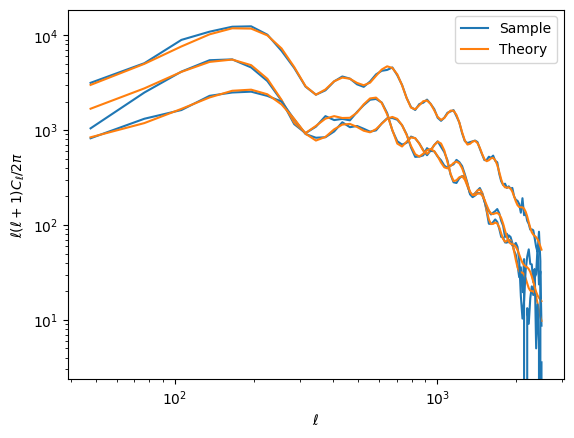

In [21]:
s = np.array([cmb_generator.get_samples(l, t, noise) for t in thetas])

theory = s[:, 0, :]
sample = s[:, 1, :]

for i in range(len(sample)):
    plt.plot(l, sample[i]*(l*(l+1)/(2*np.pi)), c='C0')
    plt.plot(l, theory[i]*(l*(l+1)/(2*np.pi)), c='C1')
plt.loglog()
plt.legend(['Sample', 'Theory'])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')


We can also do this assuming no noise.

Text(0, 0.5, '$\\ell(\\ell+1)C_\\ell/2\\pi$')

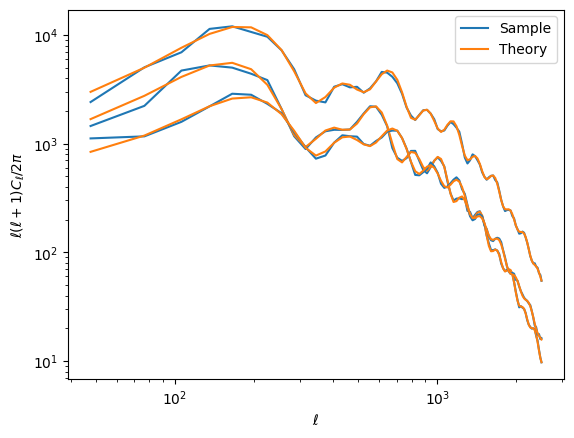

In [22]:
s = np.array([cmb_generator.get_samples(l, t) for t in thetas])

theory = s[:, 0, :]
sample = s[:, 1, :]

for i in range(len(sample)):
    plt.plot(l, sample[i]*(l*(l+1)/(2*np.pi)), c='C0')
    plt.plot(l, theory[i]*(l*(l+1)/(2*np.pi)), c='C1')
plt.loglog()
plt.legend(['Sample', 'Theory'])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')

# Another example with WMAP

Below is a similar example with WMAP data and noise profile.

[0.18325957 0.18325957 0.18325957 0.18325957 0.18325957]


Text(0, 0.5, '$\\ell(\\ell+1)N_\\ell/2\\pi$')

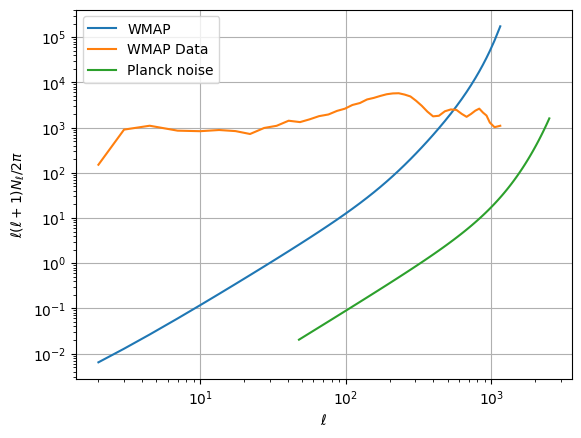

In [28]:
wmap_theta = np.array([0.82, 0.62, 0.49, 0.33, 0.21]) # in degrees
wmap_theta *= np.pi/180 # convert to radians

# hmm not sure about this... 
#taken from https://wmap.gsfc.nasa.gov/mission/observatory_sens.html#:~:text=WMAP%20Sensitivity,x%200.3°%20square%20pixel.
wmap_noise = np.array([35, 35, 35, 35, 35])*(0.3)*np.pi/180
print(wmap_noise)


# nine year binned wmap data
wmap = np.loadtxt('wmap_binned.txt')
lwmap = wmap[:, 0]

wnoise = cmb_generator.get_noise(lwmap, theta=wmap_theta, 
                                 sigma_T=wmap_noise)

# nine year binned wmap data
wmap = np.loadtxt('wmap_binned.txt')

plt.plot(lwmap, wnoise*(lwmap*(lwmap+1)/(2*np.pi)), label='WMAP')
plt.plot(lwmap, wmap[:, 3], label='WMAP Data')
plt.plot(l, noise*(l*(l+1)/(2*np.pi)), label='Planck noise')
plt.legend()
plt.loglog()
plt.grid()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)N_\ell/2\pi$')



/Users/harrybevins/Documents/Current-projects/cmb-likelihood/tools/cmb.py:133: RuntimeWarning: divide by zero encountered in divide
  cl *= (2*np.pi)/(np.arange(len(cl))*(np.arange(len(cl))+1)) # convert to C_l
/Users/harrybevins/Documents/Current-projects/cmb-likelihood/tools/cmb.py:133: RuntimeWarning: invalid value encountered in multiply
  cl *= (2*np.pi)/(np.arange(len(cl))*(np.arange(len(cl))+1)) # convert to C_l


Text(0, 0.5, '$\\ell(\\ell+1)C_\\ell/2\\pi$')

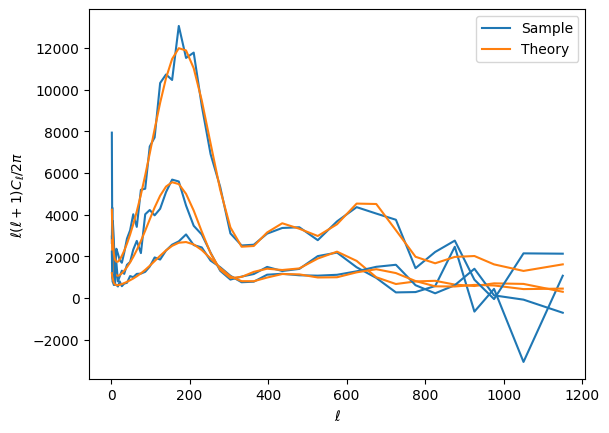

In [29]:
s = np.array([cmb_generator.get_samples(lwmap, t, wnoise) for t in thetas])

theory = s[:, 0, :]
sample = s[:, 1, :]

for i in range(len(sample)):
    plt.plot(lwmap, sample[i]*(lwmap*(lwmap+1)/(2*np.pi)), c='C0')
    plt.plot(lwmap, theory[i]*(lwmap*(lwmap+1)/(2*np.pi)), c='C1')
plt.legend(['Sample', 'Theory'])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')